In [1]:
# basic imports
import random
import numpy as np
import os
import sys

# DL library imports
import torch
import segmentation_models_pytorch as smp
# import torch.nn as nn
# import torch.nn.functional as F

# libraries for loading image, plotting 
# import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
model_dir = '/home/j/j_sten07/palma_models'
# model_name = 'UNet_baseline_last.pt'
# model_name = 'segformer_30epochs_jaccardloss_0.0003lr_best.pt'
model_name = 'unet_50epochs_jaccardloss_0.0003lr_8batches_last.pt'
data_path = '/home/j/j_sten07/thesis_test/data/Potsdam/patches/500px'

In [3]:
# load dataset and create data loader
sys.path.append('..')
from utils import make_loader, load_datasets
train_dataset, val_dataset, test_dataset = load_datasets(data_path)
train_loader, val_loader, test_loader = make_loader(train_dataset, val_dataset, test_dataset)

In [4]:
from utils import IoU                  # metric class
from utils import evaluate_model

import sys
# from models import UNet, UNetEncoder, UNetDecoder

In [5]:
# load model
# MODEL_PATH = os.path.join(output_path,MODEL_NAME, MODEL_NAME+'_best.pt')
MODEL_PATH = os.path.join(model_dir, model_name)
checkpoint = torch.load(MODEL_PATH)
model = checkpoint['model']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
criterion = smp.losses.JaccardLoss('multiclass', log_loss = False, smooth=0.0)
NUM_CLASSES = 6
# model.to(device)
# model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

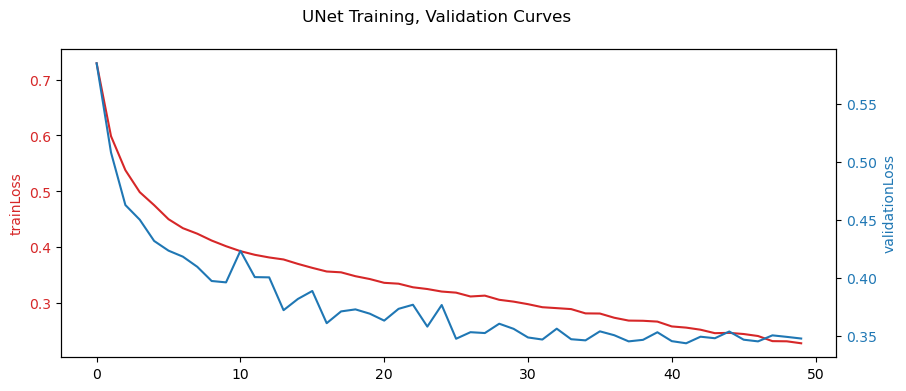

In [6]:
from utils import plot_training_results

results_df = pd.DataFrame(checkpoint['results'])
plot_training_results(results_df, 'UNet')

In [7]:
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


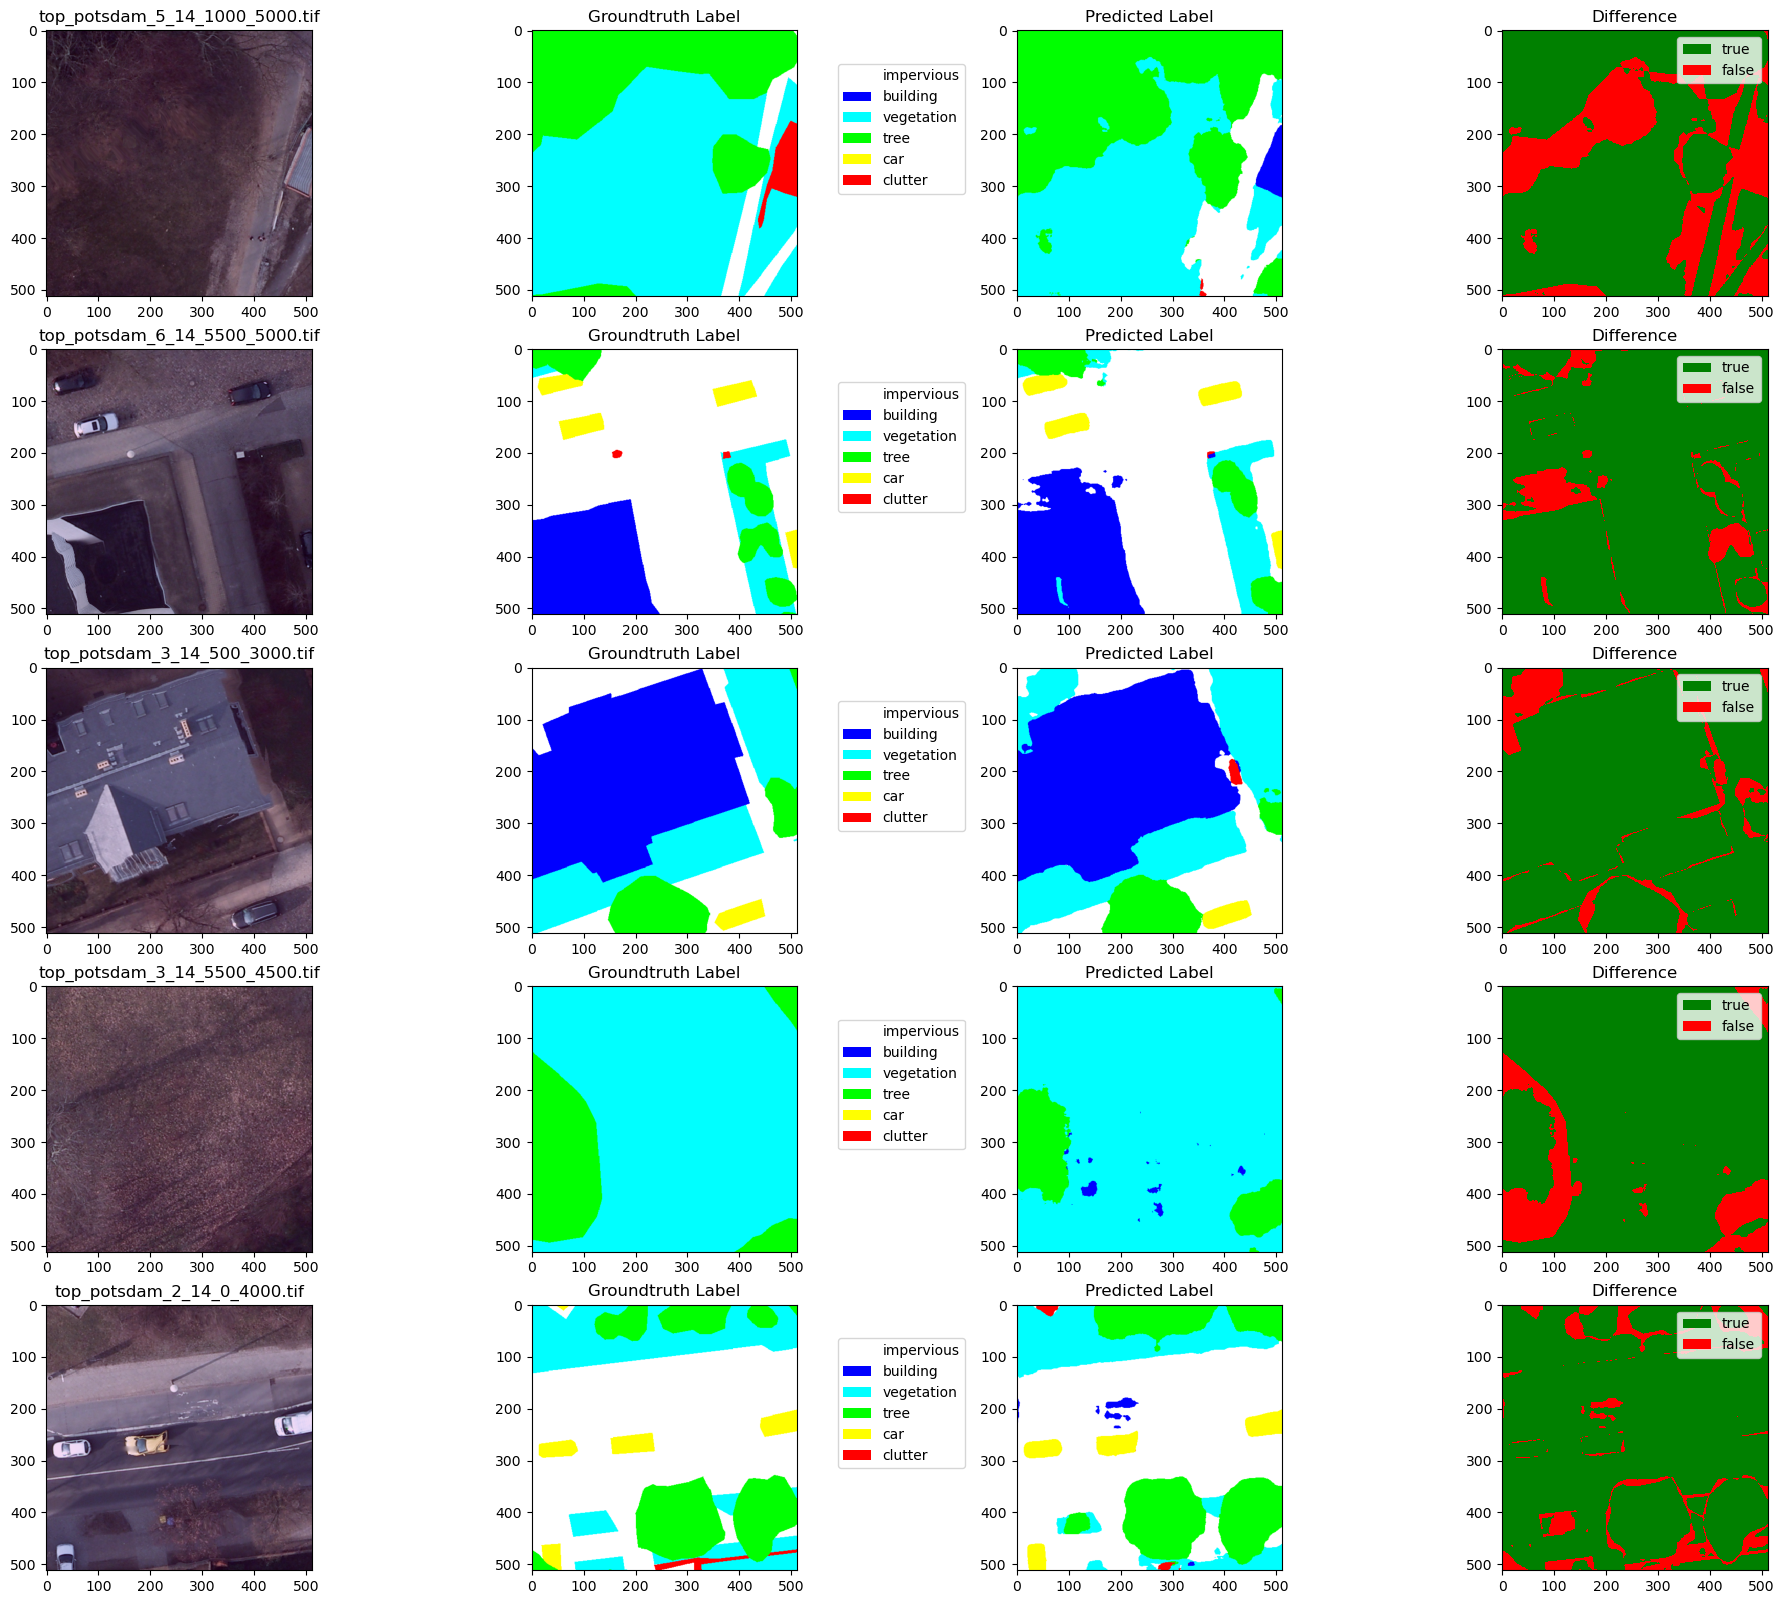

In [8]:
# plot test predictions
from utils import visualize_predictions, train_id_to_color, drivables

num_test_samples = 5
_, axes = plt.subplots(num_test_samples, 4, figsize=(4*6, num_test_samples * 4))
visualize_predictions(model, test_dataset, axes, device, numTestSamples=num_test_samples, id_to_color=train_id_to_color)

In [9]:
# evaluate model performance on test dataset
_, test_metric = evaluate_model(model, test_loader, criterion, IoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} metrices in test set")

  7%|▋         | 25/360 [00:07<01:43,  3.23it/s]


KeyboardInterrupt: 

In [ ]:
# 1. Run model on test dataset
# 2. Visualize matrix

In [12]:
hist = results_df.metrices[len(results_df)-1] ['matrix']
hist

array([[4.9587007e+07, 2.6970690e+06, 3.0440110e+06, 1.2637410e+06,
        1.2117700e+05, 3.5625800e+05],
       [1.4924490e+06, 4.5949496e+07, 8.5598600e+05, 3.0600700e+05,
        5.2410000e+03, 1.5546400e+05],
       [1.6256800e+06, 7.4506300e+05, 3.6562983e+07, 2.7248190e+06,
        4.7470000e+03, 1.7925300e+05],
       [1.7102170e+06, 3.4400000e+05, 4.0873700e+06, 2.5282746e+07,
        6.6064000e+04, 4.9743000e+04],
       [2.2883400e+05, 8.2471000e+04, 1.1526000e+04, 5.7390000e+04,
        2.8989220e+06, 7.0072000e+04],
       [2.1314370e+06, 1.3374470e+06, 1.3766570e+06, 3.5493200e+05,
        7.7571000e+04, 8.9983000e+05]])

In [ ]:
# get matrix from results
# results = results_df.metrices[len(results_df)-1] 
results = test_metric
matrix = results['matrix']
# calculate recall and respective values for wrong segmentations
matrix_per = matrix / matrix.sum(axis = 1)[np.newaxis].T # transpose sum to apply divison to rows
recall = np.diag(matrix_per)
# other metrices
precision = np.diag(matrix / matrix.sum(axis = 0))
f1 = 2*precision*recall / (precision+recall)

In [ ]:
# classes as captions for table
CLASSES = ['impervious', 'building', 'vegetation', 'tree', 'car', 'clutter']

In [ ]:
# make df and add column names and ids
df = pd.DataFrame(matrix_per)
df.columns = [s + '_pred' for s in CLASSES]
df.index = [s + '_tr' for s in CLASSES]
# add metrices
df.loc['Precision'] = precision
df.loc['Recall'] = recall
df.loc['f1'] = f1
df.loc['IoU'] = results['classwise_iou']

In [ ]:
print('Metrices')
print(f'Accuracy: {results["accuracy"]}, MeanIoU: {results["miou"]},f1 score mean: {results["f1_mean"]}')
print('"row predicted as column"')
df